In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import linear_functions as lf
import statsmodels.api as sm
import csv
import matplotlib.pyplot as plt

In [2]:
### Script Parameters
#####################

random_state = 1
test_size = 0.2

dataset_mode = "pan-cancer"
target_outputs = "top100"
alpha = 0.05

In [3]:
### DepMap Gene Expression (TPMLogp1)
#####################################
depmap_gene_exp_23Q2 = pd.read_csv("../../datasets/depmap_datasets/23Q2/OmicsExpressionProteinCodingGenesTPMLogp1.csv")
depmap_gene_exp_23Q2.set_index("Unnamed: 0", inplace=True)
depmap_gene_exp_23Q2.index.name = None
depmap_gene_exp_23Q2.sort_index(axis=0, inplace=True)
depmap_gene_exp_23Q2.sort_index(axis=1, inplace=True)
depmap_gene_exp_23Q2.dropna(axis=1, inplace=True)
depmap_gene_exp_23Q2.columns = lf.extract_gene_names(depmap_gene_exp_23Q2.columns)

### DepMap Gene Effects (CHRONOS)
#################################
depmap_gene_effect_23Q2 = pd.read_csv('../../datasets/depmap_datasets/23Q2/CRISPRGeneEffect.csv')
depmap_gene_effect_23Q2.set_index("ModelID", inplace=True)
depmap_gene_effect_23Q2.index.name = None
depmap_gene_effect_23Q2.sort_index(axis=0, inplace=True)
depmap_gene_effect_23Q2.sort_index(axis=1, inplace=True)
depmap_gene_effect_23Q2.dropna(axis=1, inplace=True)
depmap_gene_effect_23Q2.columns = lf.extract_gene_names(depmap_gene_effect_23Q2.columns)

### TRCC Gene Expression (TPMLogp1)
###################################
DFCI_gene_exp = pd.read_csv("../../datasets/tRCC_cell_lines/raw/RSEM_summary_all_samples_gene_TPM.txt", sep="\t").set_index("gene_id")

STFE1 = pd.read_csv("../../datasets/tRCC_cell_lines/raw/F1.genes.results", sep="\t").set_index("gene_id")["TPM"]
STFE2 = pd.read_csv("../../datasets/tRCC_cell_lines/raw/F2.genes.results", sep="\t").set_index("gene_id")["TPM"]
STFE3 = pd.read_csv("../../datasets/tRCC_cell_lines/raw/F3.genes.results", sep="\t").set_index("gene_id")["TPM"]
STFE_means = pd.concat([STFE1, STFE2, STFE3], axis=1).dropna(axis=1).mean(axis=1)
STFE_means.name = "STFE"

FUUR1_means = DFCI_gene_exp[['B19', 'B20', 'B21']].mean(axis=1)
UOK109_means = DFCI_gene_exp[['B10', 'B11', 'B12']].mean(axis=1)

tRCC_gene_exp = pd.DataFrame({
    'FUUR1': FUUR1_means,
    'UOK109': UOK109_means
}, index=DFCI_gene_exp.index)

tRCC_gene_exp = tRCC_gene_exp.join(STFE_means, how="outer")

tRCC_gene_exp.index.name = None
tRCC_gene_exp.index = tRCC_gene_exp.index.str.split('_').str[-1]
tRCC_gene_exp.sort_index(axis=0, inplace=True)
tRCC_gene_exp.sort_index(axis=1, inplace=True)
tRCC_gene_exp = np.log1p(tRCC_gene_exp)
tRCC_gene_exp = tRCC_gene_exp.groupby(tRCC_gene_exp.index).sum().T
tRCC_gene_exp.to_csv("../../datasets/tRCC_cell_lines/tRCC_gene_exp_TPMLogp1.csv")

### TRCC Gene Effects (CHRONOS)
###############################
DFCI_chronos_dataset = pd.read_csv("../../datasets/tRCC_cell_lines/Chronos/tRCC_chronos_summary_for_BL_ASPS_updated.csv")
DFCI_chronos_CCLs = DFCI_chronos_dataset[["Gene", "PC3", "CAKI2", "CAKI1", "786O", "DU145", "HCT116", "NCIH460", "FUUR1", "STFE", "UOK109"]].T
DFCI_chronos_CCLs.columns = DFCI_chronos_CCLs.iloc[0]
DFCI_chronos_CCLs.columns.name = None
DFCI_chronos_CCLs.drop(DFCI_chronos_CCLs.index[0], inplace=True)
DFCI_chronos_CCLs = DFCI_chronos_CCLs.loc[:, ~(DFCI_chronos_CCLs == 'Unknown').any(axis=0)].apply(pd.to_numeric, errors='coerce').dropna(axis=1)

tRCC_chronos_gene_effects = DFCI_chronos_CCLs.loc[["FUUR1", "STFE", "UOK109"]]
tRCC_chronos_gene_effects.sort_index(axis=0, inplace=True)
tRCC_chronos_gene_effects.sort_index(axis=1, inplace=True)

### Standardise Rows and Columns Between dataframes
###################################################
depmap_gene_exp_23Q2, depmap_gene_effect_23Q2 = lf.intersect_df([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2])
tRCC_gene_exp, tRCC_chronos_gene_effects = lf.intersect_df([tRCC_gene_exp, tRCC_chronos_gene_effects])
depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, tRCC_gene_exp, tRCC_chronos_gene_effects = lf.intersect_df([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, tRCC_gene_exp, tRCC_chronos_gene_effects], match="columns")

print("DepMap dataset row/column check: ", lf.check_df_similarity([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2]))
print("tRCC dataset row/column check: ", lf.check_df_similarity([tRCC_gene_exp, tRCC_chronos_gene_effects]))
print("Check columns across DepMap and tRCC dataframes: ", lf.check_df_similarity([depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, tRCC_gene_exp, tRCC_chronos_gene_effects], check="columns"))

if dataset_mode == "pan-cancer":
    X_train, X_test, Y_train, Y_test = train_test_split(depmap_gene_exp_23Q2, depmap_gene_effect_23Q2, test_size=test_size, random_state=random_state)

elif dataset_mode == "RCC":
    depmap_RCC_data = pd.read_csv("../../datasets/depmap_datasets/CCLIDs/RCC_depmap_data.csv")
    RCC_depmap_gene_exp_23Q2 = depmap_gene_exp_23Q2[depmap_gene_exp_23Q2.index.isin(depmap_RCC_data["depmapId"])]
    RCC_depmap_gene_effect_23Q2 = depmap_gene_effect_23Q2[depmap_gene_effect_23Q2.index.isin(depmap_RCC_data["depmapId"])]

    X_train, X_test, Y_train, Y_test = train_test_split(RCC_depmap_gene_exp_23Q2, RCC_depmap_gene_effect_23Q2, test_size=test_size, random_state=random_state)

elif dataset_mode == "ccRCC":
    depmap_ccRCC_data = pd.read_csv('../../datasets/depmap_datasets/CCLIDs/ccRCC_depmap_data.csv')
    ccRCC_depmap_gene_exp_23Q2 = depmap_gene_exp_23Q2[depmap_gene_exp_23Q2.index.isin(depmap_ccRCC_data["depmapId"])]
    ccRCC_depmap_gene_effect_23Q2 = depmap_gene_effect_23Q2[depmap_gene_effect_23Q2.index.isin(depmap_ccRCC_data["depmapId"])]

    X_train, X_test, Y_train, Y_test = train_test_split(ccRCC_depmap_gene_exp_23Q2, ccRCC_depmap_gene_effect_23Q2, test_size=test_size, random_state=random_state)

### Essential Genes
###################
top_common_essential_genes = pd.read_csv("../../analysis/testGenes/top_common_essential_genes")["gene"]
top100_essential_genes = pd.read_csv("../../analysis/testGenes/top_essential_genes")["Gene"]

if target_outputs == "common-essential":
    target_outputs = top_common_essential_genes

elif target_outputs == "top100":
    target_outputs = top100_essential_genes

DepMap dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
tRCC dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
Check columns across DepMap and tRCC dataframes:  {'all_match': True, 'column_differences': [[], [], [], []]}


In [4]:
if os.path.exists("../geneFeatures") == False:
    os.makedirs("../geneFeatures")

feature_lists = {}
for output in target_outputs:

    if os.path.exists("../geneFeatures/{0}.csv".format(output)) == False:

        selected_features = lf.select_features(X_train, Y_train[output])

        with open("../geneFeatures/{0}.csv".format(output), "w", newline="") as file:
            writer = csv.writer(file)

            for feature in selected_features:
                writer.writerow([feature])
        
        feature_lists[output] = selected_features

    else:
        features = []
        with open("../geneFeatures/{0}.csv".format(output), "r", newline="") as file:
            reader = csv.reader(file)

            for row in reader:
                features.append(row)

        feature_lists[output] = [x[0] for x in features]

In [5]:
train_results = {}
test_results = {}

for output in target_outputs:

    if output not in feature_lists:
        raise KeyError(f"'{output}' not found in feature lists.")
    
    model = lf.train_mLinear_model(X_train, Y_train[output], feature_lists[output])

    Y_train_act, Y_train_pred, train_pearson_corr, train_RMSE, train_MAE, train_RSquared = lf.predict_mLinear_model(X_train, Y_train[output], model, feature_lists[output])
    Y_test_act, Y_test_pred, test_pearson_corr, test_RMSE, test_MAE, test_RSquared = lf.predict_mLinear_model(X_test, Y_test[output], model, feature_lists[output])

    train_results[output] = [Y_train_act, Y_train_pred, train_pearson_corr, train_RMSE, train_MAE, train_RSquared]
    test_results[output] = [Y_test_act, Y_test_pred, test_pearson_corr, test_RMSE, test_MAE, test_RSquared]

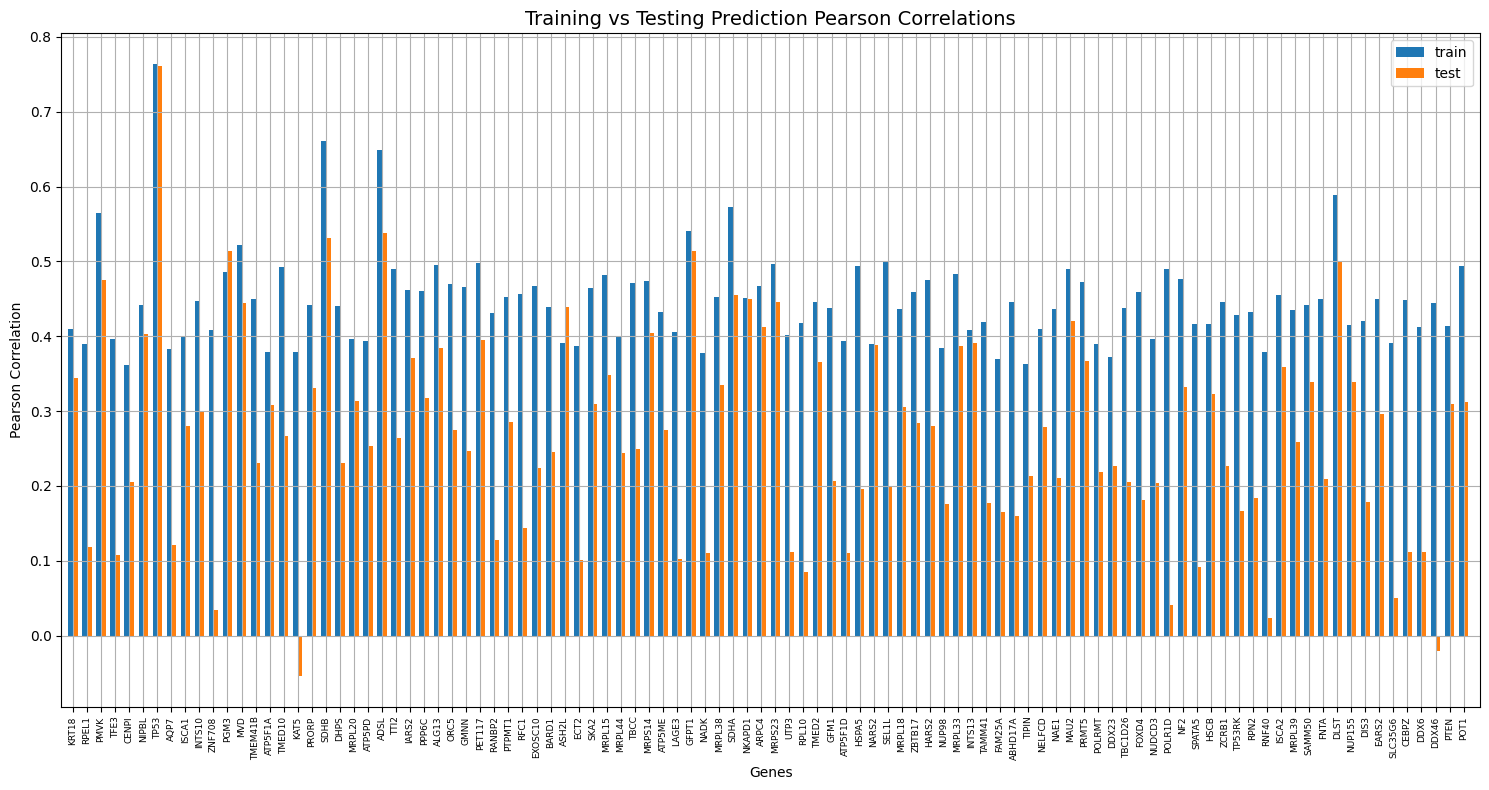

In [6]:
pearson_corrs = {'gene': [], 'train': [], 'test': []}

for gene in target_outputs:
    if gene in train_results and gene in test_results:
        pearson_corrs['gene'].append(gene)
        pearson_corrs['train'].append(train_results[gene][2]["corr"])
        pearson_corrs['test'].append(test_results[gene][2]["corr"])

corrs_df = pd.DataFrame(pearson_corrs)
corrs_df = corrs_df.set_index('gene')

lf.bar_chart_multi_col(df=corrs_df,
                    columns_to_plot=["train", "test"],
                    plot_size=(15, 8),
                    space_between_groups=0.75,
                    axes_labels=['Genes', 'Pearson Correlation'],
                    axes_labels_fontsize=10,
                    main_title='Training vs Testing Prediction Pearson Correlations',
                    main_title_fontsize=14,
                    xticks_rot=90,
                    xticks_fontsize=6.5)

In [7]:
test_corrs_df = corrs_df[["test"]]
sig_test_corrs = [gene for gene, values in test_results.items() if values[2]["p-value"] < alpha]
sig_test_corrs_df = test_corrs_df.loc[sig_test_corrs]

print("Average pearson correlation: {0}".format(test_corrs_df["test"].mean()))
print("Average significant pearson correlation: {0}".format(sig_test_corrs_df["test"].mean()))

pearson_corr_table = lf.calc_corr_freq(sig_test_corrs_df, "test")
pearson_corr_table = pearson_corr_table.set_index("Deciles")
pearson_corr_table.index = pearson_corr_table.index.map(str)

Average pearson correlation: 0.26773622362123534
Average significant pearson correlation: 0.31222689400087006


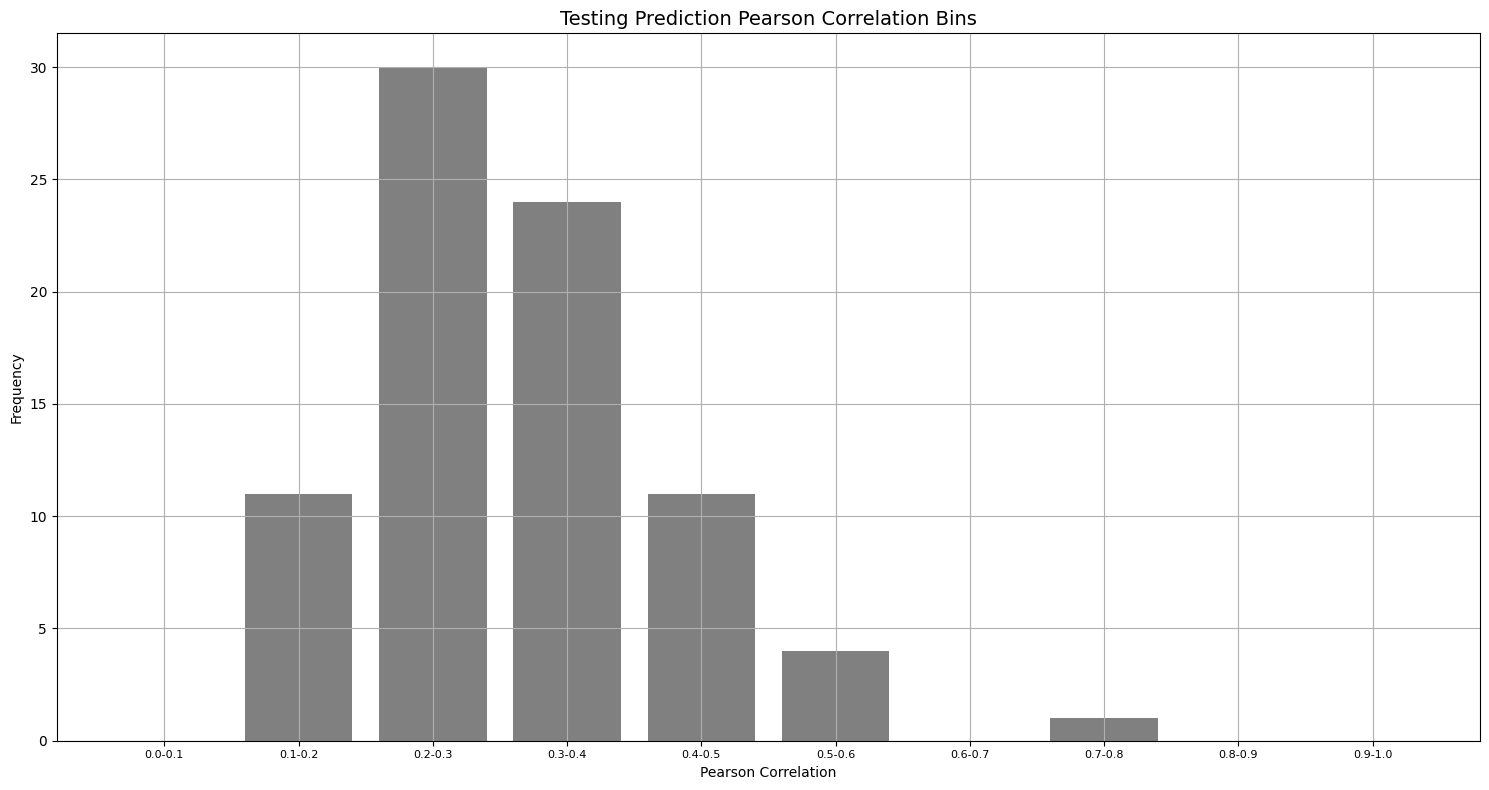

In [8]:
lf.bar_chart_sing_col(df=pearson_corr_table,
                   column="Frequency",
                    plot_size=(15, 8),
                    bar_width=0.8,
                    left_space=0.8,
                    right_space=0,
                    axes_labels=['Pearson Correlation', 'Frequency'],
                    axes_labels_fontsize=10,
                    main_title='Testing Prediction Pearson Correlation Bins',
                    main_title_fontsize=14,
                    xticks_rot=0,
                    xticks_fontsize=8)

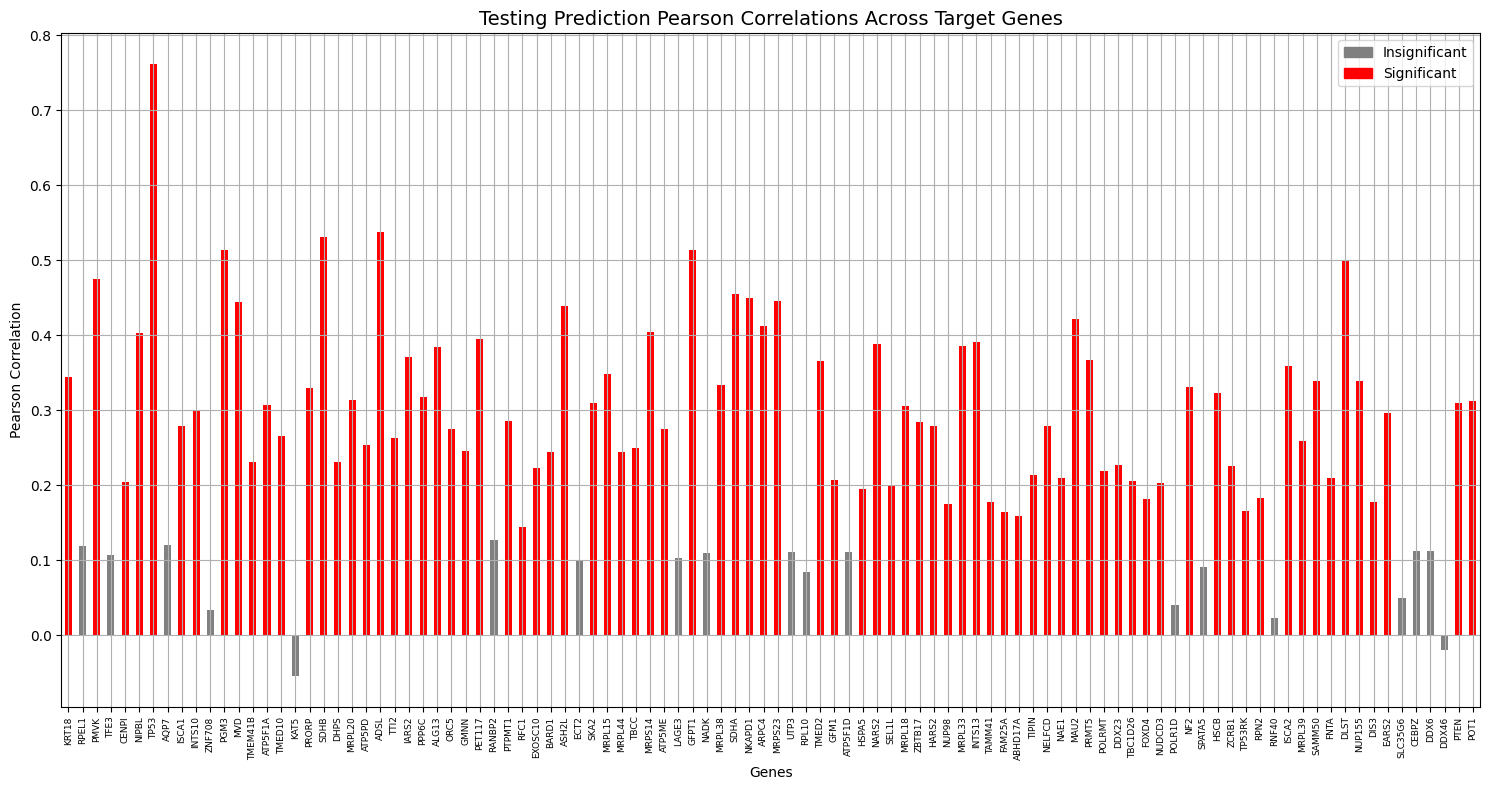

In [9]:
sig_gene_colors = {gene: "red" for gene in sig_test_corrs_df.index}

lf.bar_chart_sing_col(df=corrs_df[["test"]],
                   column="test",
                   special_colors=sig_gene_colors,
                   legend_labels={"Insignificant": "grey", "Significant": "red"},
                    plot_size=(15, 8),
                    bar_width=0.5,
                    left_space=0.5,
                    right_space=0,
                    axes_labels=['Genes', 'Pearson Correlation'],
                    axes_labels_fontsize=10,
                    main_title='Testing Prediction Pearson Correlations Across Target Genes',
                    main_title_fontsize=14,
                    xticks_rot=90,
                    xticks_fontsize=6.5)

In [10]:
Y_act_test_data = {}
Y_pred_test_data = {}

for gene, values in test_results.items():
    Y_act_test_data[gene] = values[0] 
    Y_pred_test_data[gene] = values[1] 

Y_act_test_df = pd.DataFrame(Y_act_test_data)
Y_pred_test_df = pd.DataFrame(Y_pred_test_data)

Y_act_train_data = {}
Y_pred_train_data = {}

for gene, values in train_results.items():
    Y_act_train_data[gene] = values[0]  
    Y_pred_train_data[gene] = values[1]  

Y_act_train_df = pd.DataFrame(Y_act_train_data)
Y_pred_train_df = pd.DataFrame(Y_pred_train_data)

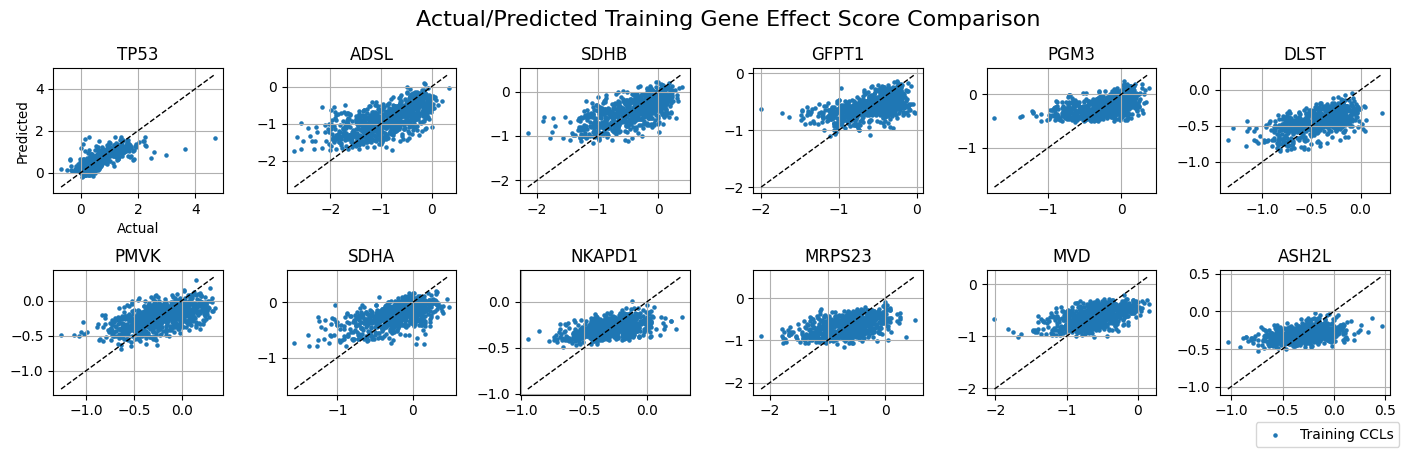

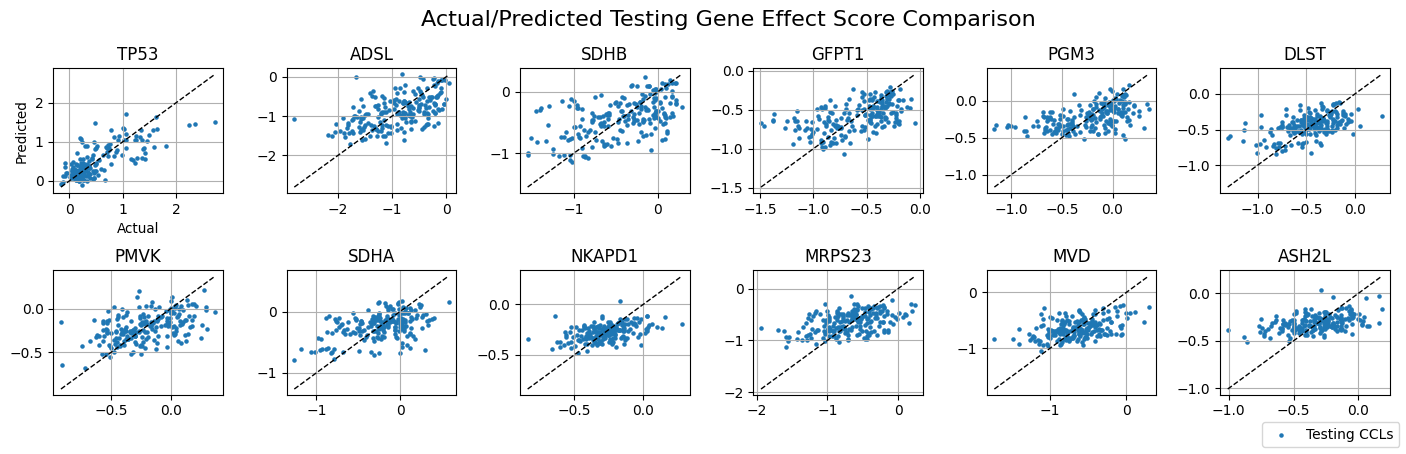

In [23]:
top12_corrs_sig = sig_test_corrs_df.sort_values(by="test", ascending=False).index[:12]

lf.predictions_miniplot(Y_act1=Y_act_train_df,
                        Y_pred1=Y_pred_train_df,
                        genes=top12_corrs_sig,
                        alpha_dict={"rel1": 1},
                        main_title="Actual/Predicted Training Gene Effect Score",
                        axes_labels=["Actual", "Predicted"],
                        axis_label_fontsize=9.75,
                        legend_titles={"rel1": "Training CCLs"},
                        sizeProps=[0.85, 0.125, 0.99, 0],
                        wspace=0.375,
                        hspace=0.625,
                        equal_axes_scale=False)

lf.predictions_miniplot(Y_act1=Y_act_test_df,
                        Y_pred1=Y_pred_test_df,
                        genes=top12_corrs_sig,
                        alpha_dict={"rel1": 1},
                        main_title="Actual/Predicted Testing Gene Effect Score",
                        axes_labels=["Actual", "Predicted"],
                        axis_label_fontsize=9.75,
                        legend_titles={"rel1": "Testing CCLs"},
                        sizeProps=[0.85, 0.125, 0.99, 0],
                        wspace=0.375,
                        hspace=0.625,
                        equal_axes_scale=False)

In [25]:
train_RMSE = pd.DataFrame(columns=['train'])
train_MAE = pd.DataFrame(columns=['train'])
train_RSquared = pd.DataFrame(columns=['train'])

for gene in sig_test_corrs:

    if gene in train_results:
        train_RMSE.loc[gene] = train_results[gene][3]

    if gene in train_results:
        train_MAE.loc[gene] = train_results[gene][4]

    if gene in train_results:
        train_RSquared.loc[gene] = train_results[gene][5]


test_RMSE = pd.DataFrame(columns=['test'])
test_MAE = pd.DataFrame(columns=['test'])
test_RSquared = pd.DataFrame(columns=['test'])

for gene in sig_test_corrs:

    if gene in train_results:
        test_RMSE.loc[gene] = test_results[gene][3]

    if gene in train_results:
        test_MAE.loc[gene] = test_results[gene][4]

    if gene in train_results:
        test_RSquared.loc[gene] = test_results[gene][5]

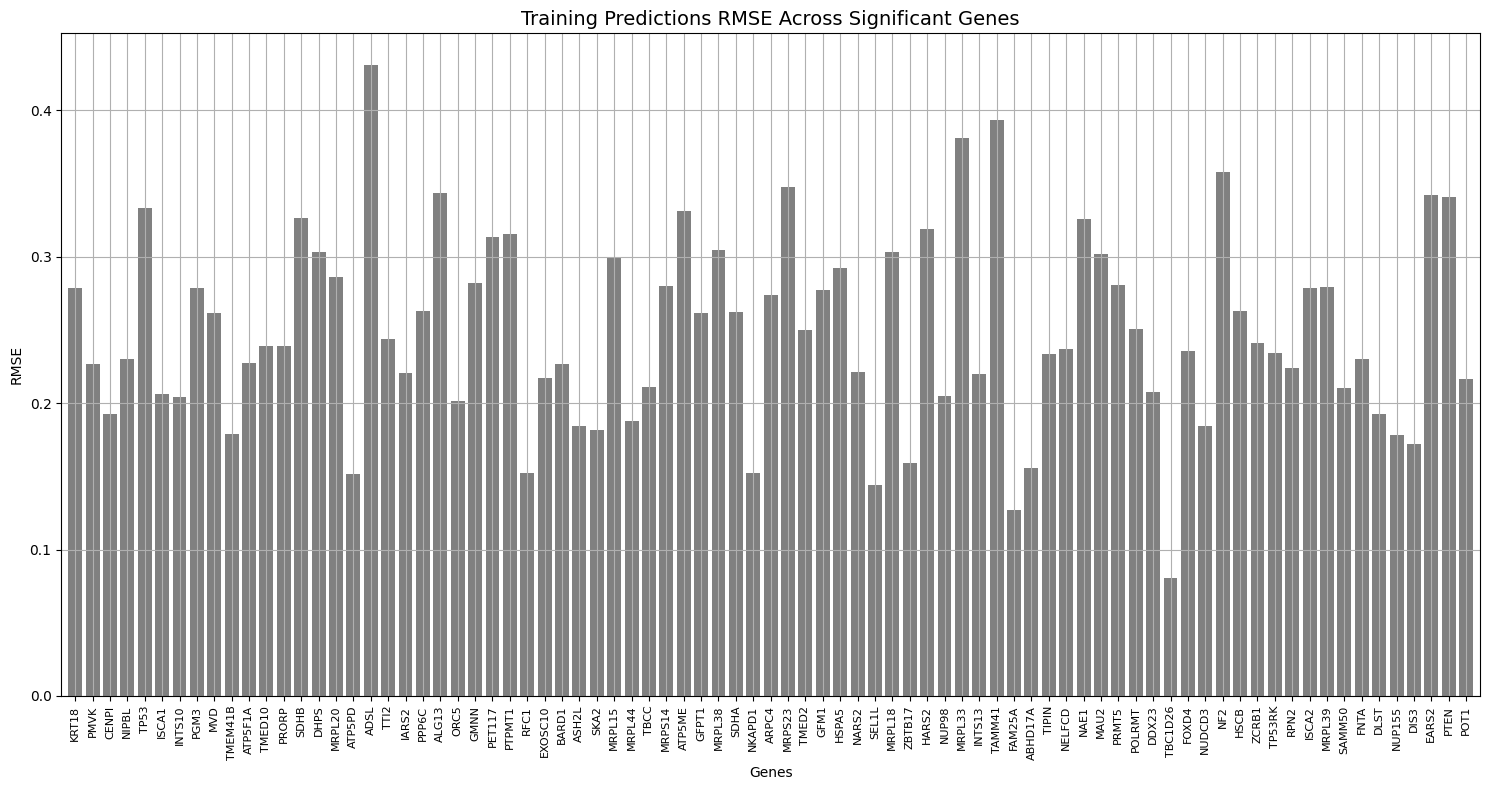

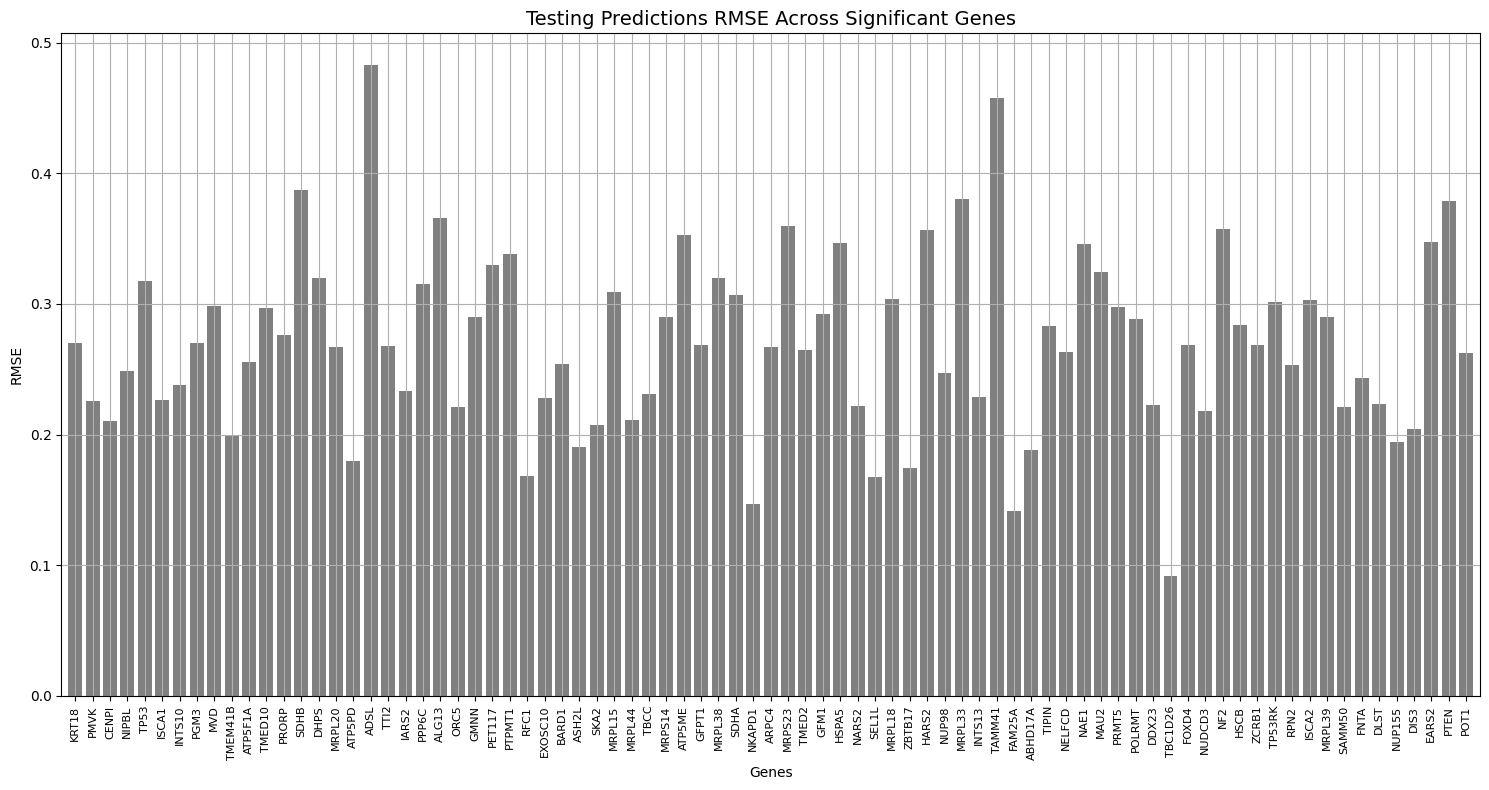

In [29]:
lf.bar_chart_sing_col(df=train_RMSE,
                   column="train",
                    plot_size=(15, 8),
                    bar_width=0.8,
                    left_space=0.8,
                    right_space=0,
                    axes_labels=['Genes', 'RMSE'],
                    axes_labels_fontsize=10,
                    main_title='Training Predictions RMSE Across Significant Genes',
                    main_title_fontsize=14,
                    xticks_rot=90,
                    xticks_fontsize=8)

lf.bar_chart_sing_col(df=test_RMSE,
                   column="test",
                    plot_size=(15, 8),
                    bar_width=0.8,
                    left_space=0.8,
                    right_space=0,
                    axes_labels=['Genes', 'RMSE'],
                    axes_labels_fontsize=10,
                    main_title='Testing Predictions RMSE Across Significant Genes',
                    main_title_fontsize=14,
                    xticks_rot=90,
                    xticks_fontsize=8)

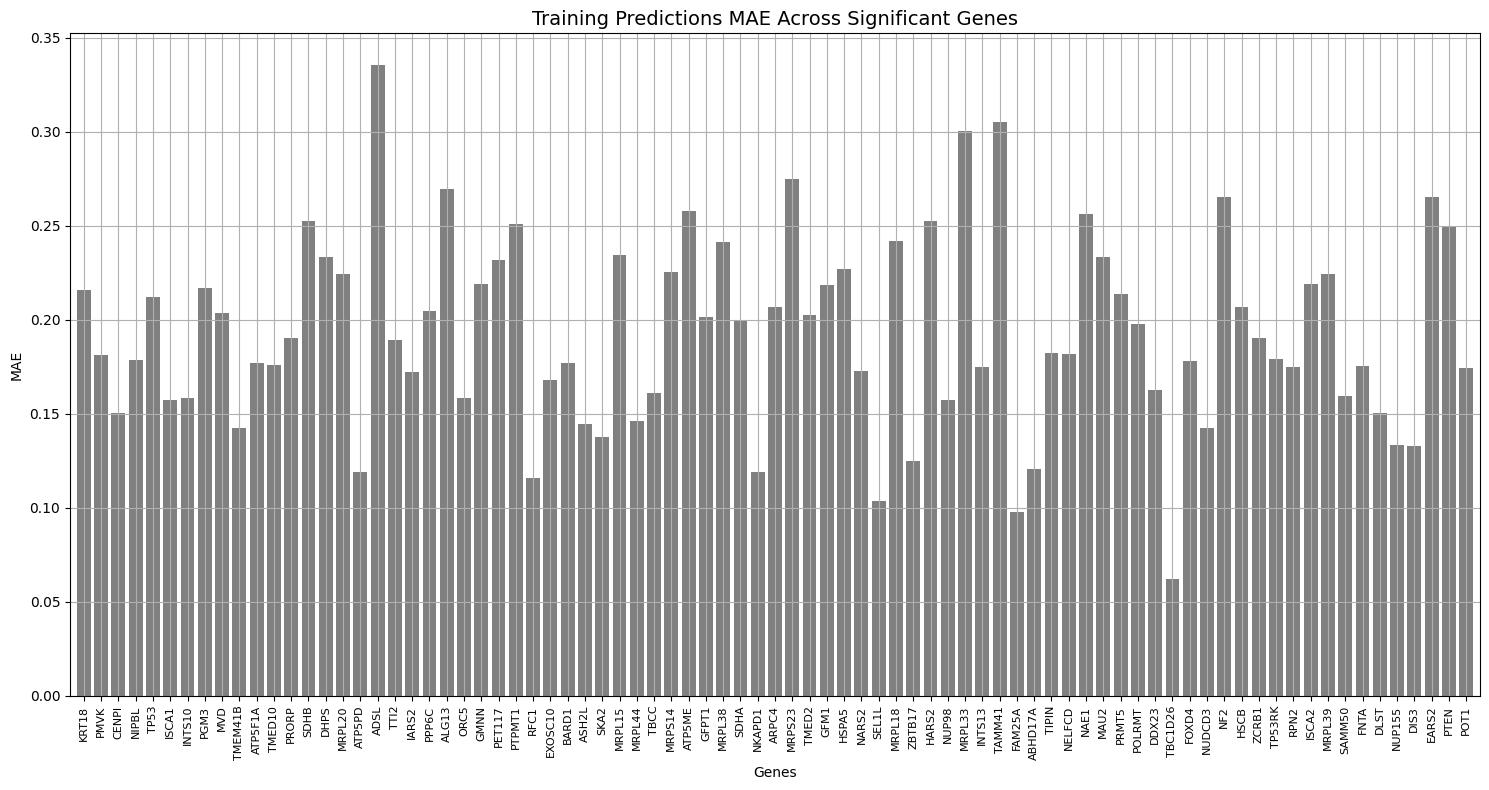

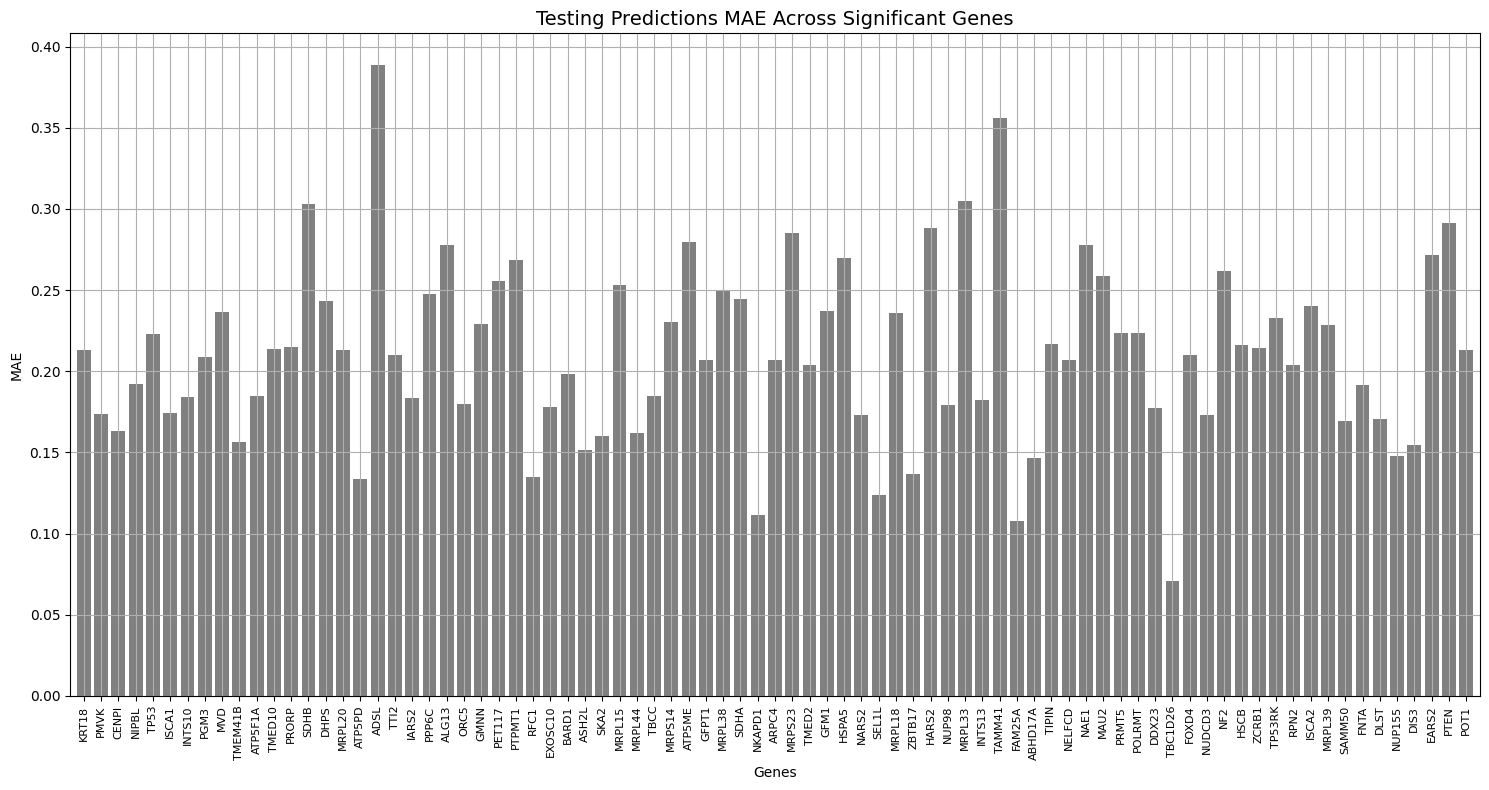

In [30]:
lf.bar_chart_sing_col(df=train_MAE,
                   column="train",
                    plot_size=(15, 8),
                    bar_width=0.8,
                    left_space=0.8,
                    right_space=0,
                    axes_labels=['Genes', 'MAE'],
                    axes_labels_fontsize=10,
                    main_title='Training Predictions MAE Across Significant Genes',
                    main_title_fontsize=14,
                    xticks_rot=90,
                    xticks_fontsize=8)

lf.bar_chart_sing_col(df=test_MAE,
                   column="test",
                    plot_size=(15, 8),
                    bar_width=0.8,
                    left_space=0.8,
                    right_space=0,
                    axes_labels=['Genes', 'MAE'],
                    axes_labels_fontsize=10,
                    main_title='Testing Predictions MAE Across Significant Genes',
                    main_title_fontsize=14,
                    xticks_rot=90,
                    xticks_fontsize=8)

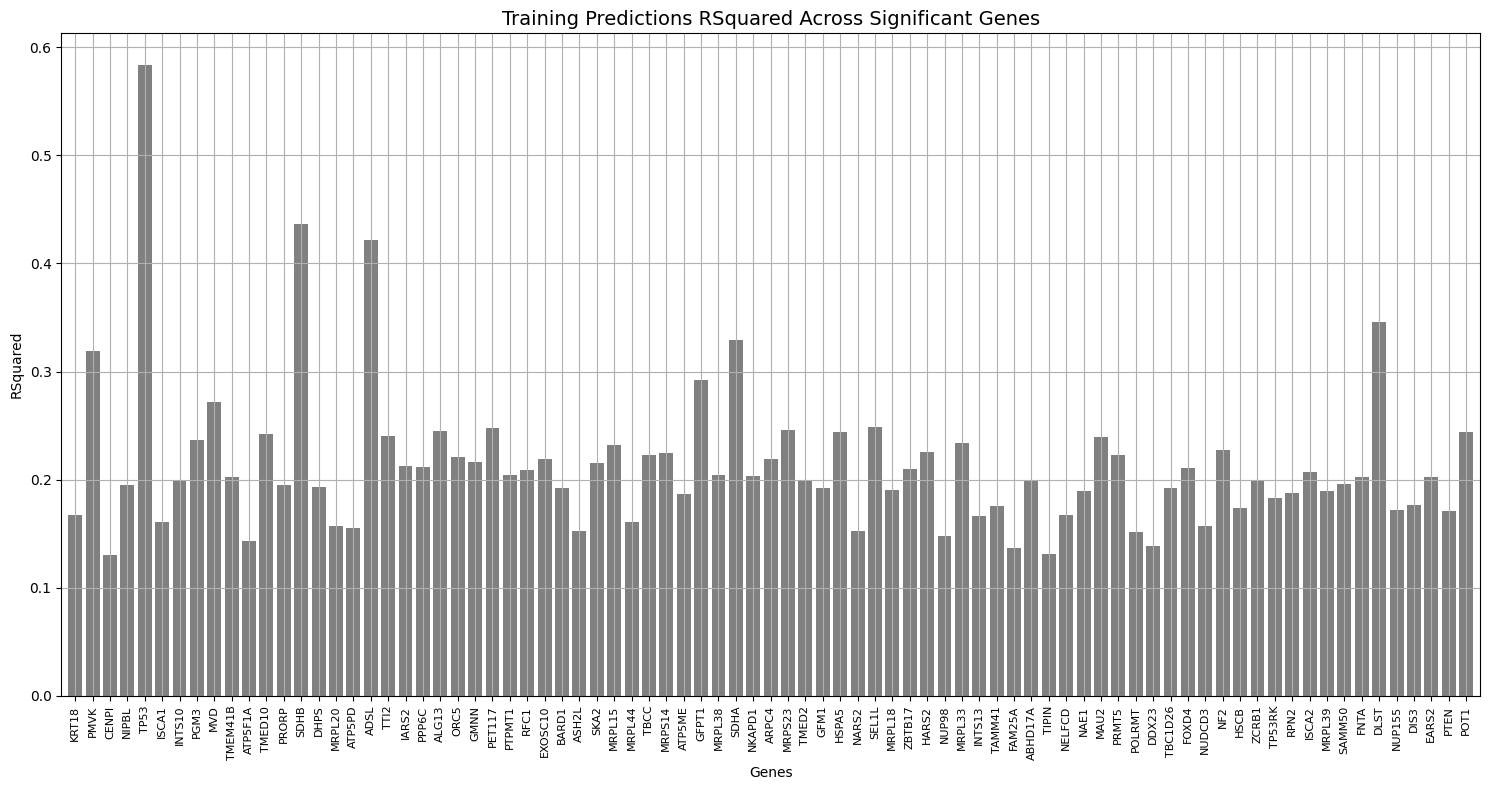

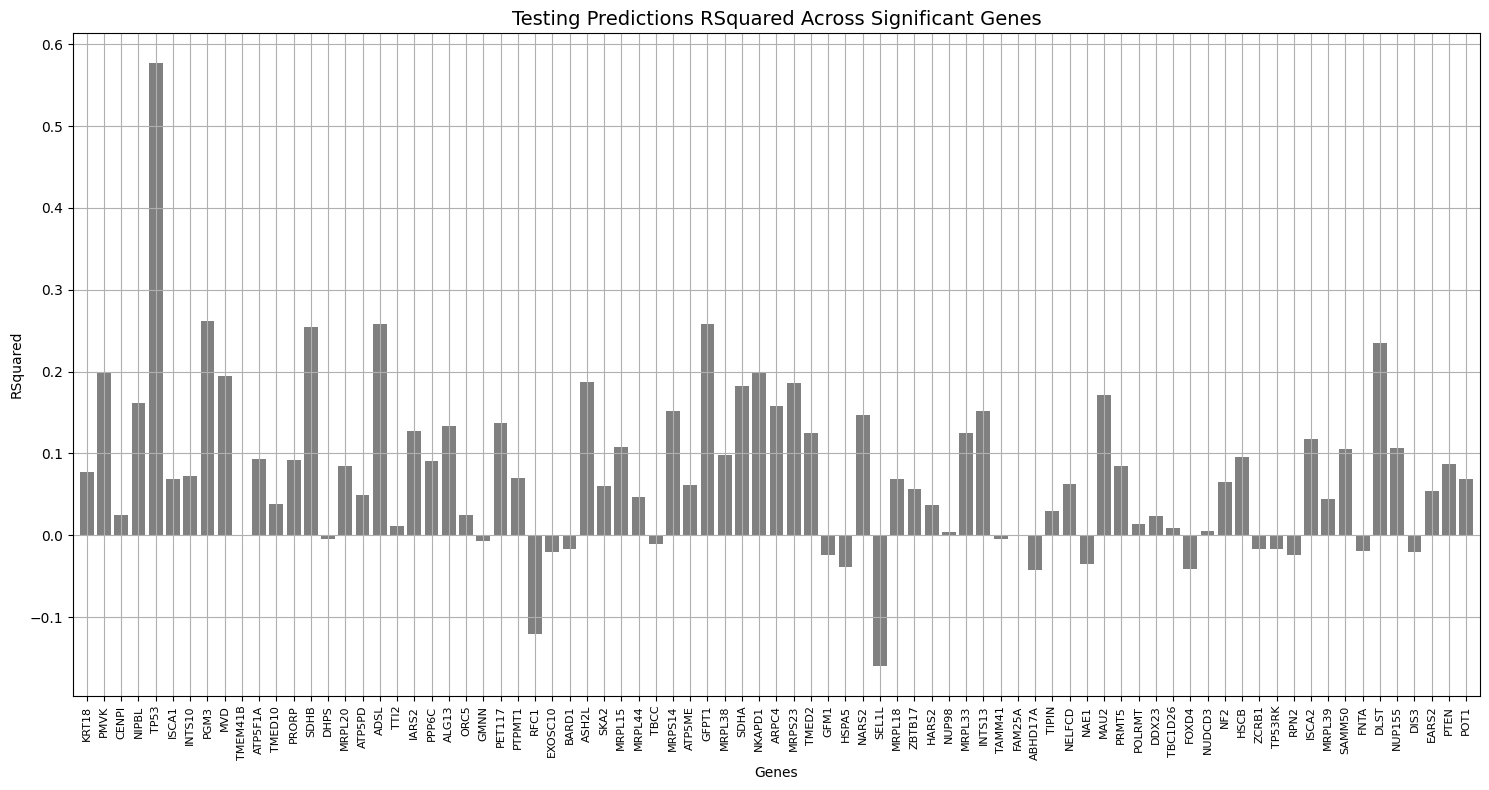

In [31]:
lf.bar_chart_sing_col(df=train_RSquared,
                   column="train",
                    plot_size=(15, 8),
                    bar_width=0.8,
                    left_space=0.8,
                    right_space=0,
                    axes_labels=['Genes', 'RSquared'],
                    axes_labels_fontsize=10,
                    main_title='Training Predictions RSquared Across Significant Genes',
                    main_title_fontsize=14,
                    xticks_rot=90,
                    xticks_fontsize=8)

lf.bar_chart_sing_col(df=test_RSquared,
                   column="test",
                    plot_size=(15, 8),
                    bar_width=0.8,
                    left_space=0.8,
                    right_space=0,
                    axes_labels=['Genes', 'RSquared'],
                    axes_labels_fontsize=10,
                    main_title='Testing Predictions RSquared Across Significant Genes',
                    main_title_fontsize=14,
                    xticks_rot=90,
                    xticks_fontsize=8)